# ML Flow on Azure ML

The ML ops demo notebook shows running ML Flow on a local machine, and the AzureML notebook demonstrates using the Azure ML SDK for experiment tracking. This notebook combines the two, using AzureML to run, but tracking through the ML Flow API with AzureML providing the backend storage. This allows us to make use of the easily scaling  infrastructure of AzureML, while the code is still portable as other backends can easily be swapped in when required.


In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
%load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [5]:
import mlflow
mlflow.tensorflow.autolog()

In [6]:
import azureml
import azureml.core

In [7]:
import prd_pipeline

In [8]:
import importlib

In [ ]:
importlib.reload(prd_pipeline)

### Load data

In [9]:
train202208_datastore_name = 'precip_rediagnosis_train202208'
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [10]:
# prd_merged_file_dataset_name = 'prd_merged_csv_files'
prd_merged_file_dataset_name = 'prd_merged_2022_storm_eunice_franklin_files'


In [11]:
azure_experiment_name='prd_mlops_test'
azure_env_name = 'prd_ml_cluster'
cluster_name = 'mlops-test'

In [12]:
prd_model_name = 'azml_mlops_202208'

In [13]:
prd_all_events_dataset_name = 'prd_merged_all_events_files'

In [14]:
target_parameter = 'rainfall_rate'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [15]:
prd_ws = azureml.core.Workspace.from_config()

In [16]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

In [17]:
%%time
input_data = prd_pipeline.load_data(
    current_ws=prd_ws,
    dataset_name=prd_all_events_dataset_name
)


Volume mount is not enabled. 
Falling back to dataflow mount.
loading all event data
CPU times: user 1min 29s, sys: 22.1 s, total: 1min 51s
Wall time: 2min 31s


In [ ]:
[c1 for c1 in input_data.columns if 'rain' in c1]

In [18]:
%%time
data_splits, data_dims = prd_pipeline.preprocess_data(
    input_data=input_data,
    test_fraction=0.2,
    feature_dict={'profile': profile_features, 'single_level': single_lvl_features,'target': target_parameter,},
)

target has dims: 13
dropping zeros
getting profile columns
['relative_humidity_5.0', 'relative_humidity_10.0', 'relative_humidity_20.0', 'relative_humidity_30.0', 'relative_humidity_50.0', 'relative_humidity_75.0', 'relative_humidity_100.0', 'relative_humidity_150.0', 'relative_humidity_200.0', 'relative_humidity_250.0', 'relative_humidity_300.0', 'relative_humidity_400.0', 'relative_humidity_500.0', 'relative_humidity_600.0', 'relative_humidity_700.0', 'relative_humidity_800.0', 'relative_humidity_1000.0', 'relative_humidity_1250.0', 'relative_humidity_1500.0', 'relative_humidity_1750.0', 'relative_humidity_2000.0', 'relative_humidity_2250.0', 'relative_humidity_2500.0', 'relative_humidity_2750.0', 'relative_humidity_3000.0', 'relative_humidity_3250.0', 'relative_humidity_3500.0', 'relative_humidity_3750.0', 'relative_humidity_4000.0', 'relative_humidity_4500.0', 'relative_humidity_5000.0', 'relative_humidity_5500.0', 'relative_humidity_6000.0', 'air_temperature_5.0', 'air_temperature

In [19]:
nprof_features = data_dims['nprof_features'] 
nheights = data_dims['nheights']
nsinglvl_features = data_dims['nsinglvl_features']

In [34]:
prd_experiment_name = 'prd_exp_azml_mlflow'

In [20]:
exp1 = mlflow.create_experiment(prd_experiment_name)
exp1

'f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9'

In [21]:
exp1 = mlflow.get_experiment(exp1)

In [22]:
exp1

<Experiment: artifact_location='', experiment_id='f1ebd4da-78ee-4b70-9d2c-5b9c5fb75ea9', lifecycle_stage='active', name='prd_exp_azml_mlflow', tags={}>

In [23]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [24]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# run tensorboard --logdir LOGDIRPATH from command line to launch 

In [25]:
import tempfile

In [26]:
from azureml.tensorboard import Tensorboard


In [30]:
data_splits.keys()

dict_keys(['X_train', 'X_val', 'y_train', 'y_val'])

In [29]:
data_dims

{'nprof_features': 2, 'nheights': 33, 'nsinglvl_features': 1, 'nbands': 13}

https://prd-ml-pipeline-6006.uksouth.instances.azureml.ms
https://prd-ml-pipeline-6006.uksouth.instances.azureml.ms


2022-08-30 12:54:25.782782: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 2)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       192         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

2022-08-30 13:34:37.365785: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpttfigkw7/model/data/model/assets


2022/08/30 13:36:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: AzureMLException:
	Message: Failed to flush task queue within 120 seconds
	InnerException None
	ErrorResponse 
{
    "error": {
        "code": "UserError",
        "message": "Failed to flush task queue within 120 seconds",
        "inner_error": {
            "code": "ResourceExhausted",
            "inner_error": {
                "code": "Timeout"
            }
        }
    }
}


MAE: 0.312
R-squared score: 0.653


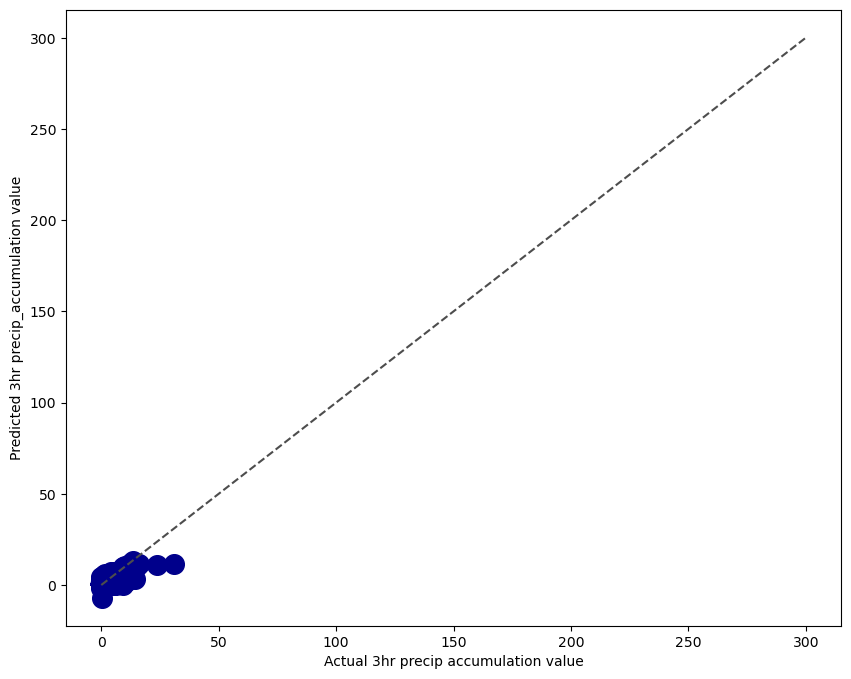

In [43]:
%%time
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
     # current run can only be obtained within a run. Once the mlflow run has been created, we will need to call Run.get_context to get ther azureml run
    azml_current_run = list(azureml.core.Experiment.list(prd_ws, prd_experiment_name)[0].get_runs())[0]
    
    prd_tb = Tensorboard([azml_current_run])

    # If successful, start() returns a string with the URI of the instance.
    prd_tb_uri = prd_tb.start()
    # print(prd_tb_uri)
    
    model = prd_pipeline.build_model(nprof_features, nheights, nsinglvl_features)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(data_splits['X_train'], data_splits['y_train'], epochs=50, batch_size=128, validation_data=(data_splits['X_val'], data_splits['y_val']), verbose=True, callbacks=[tensorflow_callback])

    y_pred = model.predict(data_splits['X_val'])
    error = mean_absolute_error(data_splits['y_val'], y_pred)
    print(f'MAE: {error:.3f}')
    rsqrd = r2_score(data_splits['y_val'], y_pred)
    print(f'R-squared score: {rsqrd:.3f}')
    
    mlflow.log_metric('MAE', error)
    mlflow.log_metric('R-squared', rsqrd)
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1)
    ax1.scatter(data_splits['y_val'], y_pred, s=200, c='darkblue')
    ax1.plot([0, 300], [0, 300], ls="--", c=".3")
    ax1.set_xlabel('Actual 3hr precip accumulation value')
    ax1.set_ylabel('Predicted 3hr precip_accumulation value')
#     with tempfile.TemporaryDirectory() as td1:
        
#         fig1.savefig(plot_out_path, bbox_inches='tight')
    mlflow.log_figure(fig1,  'actual_predicted_precip_3hr.png')                   
    # mlflow.log


If we look at the experiment in AzureML GUI, we see that all the model parameters have been automatically logged, and the model has been saved by ML Flow ready for use in inference.

In [45]:
# After your job completes, be sure to stop() the streaming otherwise it will continue to run. 
prd_tb.stop()

## Evaluation

In [47]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

In [67]:
help(mlflow.tracking.MlflowClient(prd_ws.get_mlflow_tracking_uri()).search_runs)

Help on method search_runs in module mlflow.tracking.client:

search_runs(experiment_ids: List[str], filter_string: str = '', run_view_type: int = 1, max_results: int = 1000, order_by: Union[List[str], NoneType] = None, page_token: Union[str, NoneType] = None) -> mlflow.store.entities.paged_list.PagedList[mlflow.entities.run.Run] method of mlflow.tracking.client.MlflowClient instance
    Search experiments that fit the search criteria.
    
    :param experiment_ids: List of experiment IDs, or a single int or string id.
    :param filter_string: Filter query string, defaults to searching all runs.
    :param run_view_type: one of enum values ACTIVE_ONLY, DELETED_ONLY, or ALL runs
                          defined in :py:class:`mlflow.entities.ViewType`.
    :param max_results: Maximum number of runs desired.
    :param order_by: List of columns to order by (e.g., "metrics.rmse"). The ``order_by`` column
                 can contain an optional ``DESC`` or ``ASC`` value. The default is 

In [ ]:
mlflow.tracking.MlflowClient(prd_ws.get_mlflow_tracking_uri()).search_runs(experiment_ids=[exp1.experiment_id], filter_string='', order_by='info.end_time')

In [ ]:
print('hello')

AttributeError: 'ActiveRun' object has no attribute 'log_figure'

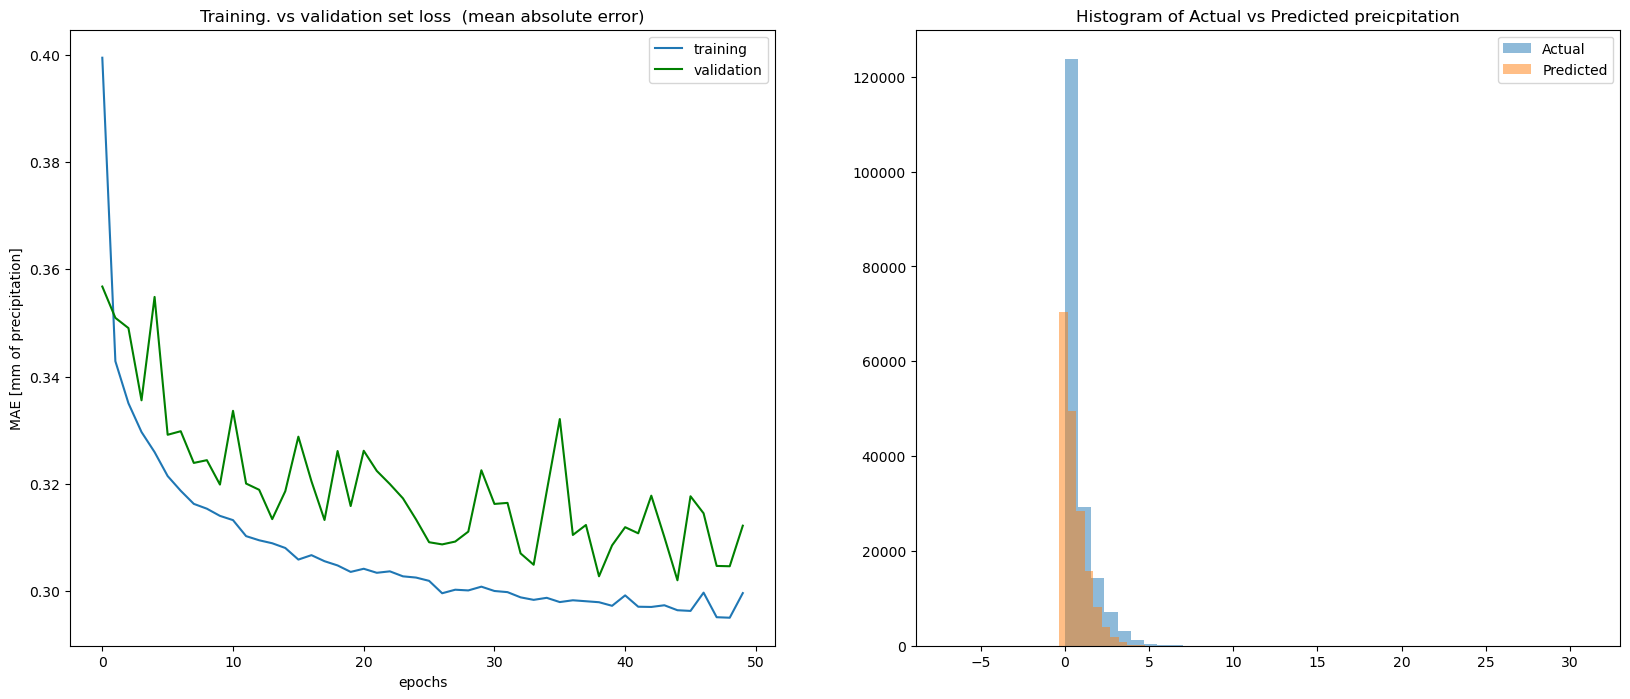

In [53]:
fig1 = plt.figure(figsize=(20, 8))

ax1 = fig1.add_subplot(1,2,1, title='Training. vs validation set loss  (mean absolute error)')
ax1.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
ax1.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
ax1.legend()
ax1.set_ylabel('MAE [mm of precipitation]')
ax1.set_xlabel('epochs')

ax2 = fig1.add_subplot(1,2,2,title='Histogram of Actual vs Predicted preicpitation')
ax2.hist(data_splits['y_val'], alpha=0.5, bins=40, label='Actual')
ax2.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
ax2.legend()

